#LSTM CNN con database FASHION MNIST

*Long-Short Term Memory* neural network convoluzionale sviluppata in TensorFlow versione 1.x, su database FASHION MNIST.

In questo notebook lo scopo è testare il modello con un altro database; per spiegazioni più dettagliate, guardare la versione corrispondente al modello su database MNIST.

*Runtime -> Change runtime time -> Hardware accelerator -> GPU*.

In [1]:
%tensorflow_version 1.x

import tensorflow as tf
from tensorflow import keras as ks

print(tf.__version__)

from tensorflow.keras import layers
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import ConvLSTM2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Softmax

#Per interoperabilità di Python 2/3
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
from numpy import array
from numpy import argmax

import matplotlib.pyplot as plt

import time

import pandas as pd
from sklearn.metrics import confusion_matrix
#Per data visualization
import seaborn as sns

print("Done")

TensorFlow 1.x selected.
1.15.2
Done


##Definizione metodi

In [0]:
class TimeHistory(ks.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, epoch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array, true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(predicted_label,
                                100*np.max(predictions_array),
                                true_label),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array, true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

##Import del database

In [3]:
#Import del database MNIST
#database = tf.keras.datasets.mnist
#Import del database FASHION MNIST
database = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = database.load_data()

print("Done")

4423680/4422102 [==============================] - 0s 0us/step
Done


##Costanti e preprocessing dei dati

In [4]:
#Costanti
batch_size = 256
n_classes = 10

#Unit in first layer
num_units1 = batch_size
#Unit in second layer
num_units2 = (int)(num_units1 / 2)

time_steps = 4
n_features = 7
size_ts_blocks = 4
rows = 28
cols = 28

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

print("Done")

Done


In [5]:
#Preprocessing dei dati
#Scalo i valori nel range tra 0 e 1
train_images = train_images / 255.0

test_images = test_images / 255.0

print("Done")

Done


In [6]:
train_images = train_images.reshape(train_images.shape[0], time_steps, n_features, -1, size_ts_blocks)

test_images = test_images.reshape(test_images.shape[0], time_steps, n_features, -1, size_ts_blocks)

print(train_images.shape)
print("Done")

(60000, 4, 7, 7, 4)
Done


**Nota bene**

L'immagine è 28x28px, con alcune impostazioni di time steps e features, l'immagine risulta essere troppo piccola; il padding risolve questo problema.

##Build

In [7]:
model_CNN_LSTM = ks.Sequential()
#(samples, time, rows, cols, channels)
model_CNN_LSTM.add(ConvLSTM2D(32, (5, 5), input_shape=(time_steps, n_features, 7, size_ts_blocks), activation='relu', return_sequences='true'))
model_CNN_LSTM.add(ConvLSTM2D(32, (3, 3), activation='relu'))
model_CNN_LSTM.add(Flatten())
model_CNN_LSTM.add(Dense(64, activation='relu'))
model_CNN_LSTM.add(Dense(10, activation='softmax'))

print("Done")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Done


##Compile

In [8]:
model_CNN_LSTM.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model_CNN_LSTM.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d (ConvLSTM2D)    (None, 4, 3, 3, 32)       115328    
_________________________________________________________________
conv_lst_m2d_1 (ConvLSTM2D)  (None, 1, 1, 32)          73856     
_________________________________________________________________
flatten (Flatten)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 64)                2112      
_________________________________________________________________
dense_1 (Dense)              (None, 10)                650       
Total params: 191,946
Trainable params: 191,946
Non-trainable params: 0
_________________________________________________________________


##Training

In [9]:
#Validation_data è usato al termine di ogni epoch; il test set rimane inutilizzato per l'addestramento?
#Batch size should be (at most) the same number of hidden cells
time_callback = TimeHistory()
hist = model_CNN_LSTM.fit(train_images, train_labels, 
                     batch_size = batch_size,
                     validation_data=(test_images, test_labels), 
                     epochs=10,
                     callbacks=[time_callback])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 14s 236us/sample - loss: 0.9713 - acc: 0.6441 - val_loss: 0.6300 - val_acc: 0.7579
Epoch 2/10
60000/60000 [==============================] - 7s 119us/sample - loss: 0.5500 - acc: 0.7995 - val_loss: 0.5250 - val_acc: 0.8085
Epoch 3/10
60000/60000 [==============================] - 7s 118us/sample - loss: 0.4654 - acc: 0.8298 - val_loss: 0.4866 - val_acc: 0.8213
Epoch 4/10
60000/60000 [==============================] - 7s 116us/sample - loss: 0.4217 - acc: 0.8452 - val_loss: 0.4373 - val_acc: 0.8372
Epoch 5/10
60000/60000 [==============================] - 7s 118us/sample - loss: 0.3906 - acc: 0.8554 - val_loss: 0.4214 - val_acc: 0.8452
Epoch 6/10
60000/60000 [==============================] - 7s 120us/sample - loss: 0.3724 - acc: 0.8617 - val_loss: 0.4037 - val_acc: 0.8540
Epoch 7/10
6000

In [10]:
#Misuro accuratezza
test_accuracy = model_CNN_LSTM.evaluate(test_images, test_labels)

print("Accuratezza: " + str(test_accuracy))
print("Done")

10000/10000 [==============================] - 3s 288us/sample - loss: 0.3586 - acc: 0.8701
Accuratezza: [0.3586360828757286, 0.8701]
Done


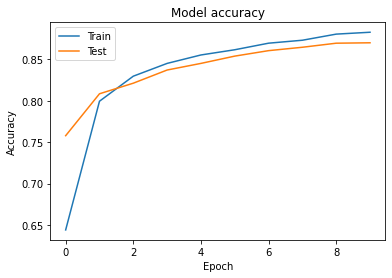

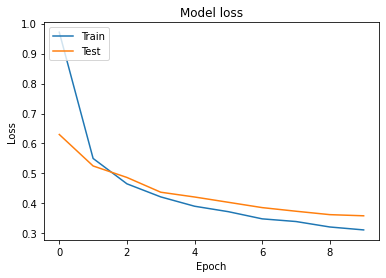

Time per epoch: [14.183288097381592, 7.161547899246216, 7.089440584182739, 6.971004962921143, 7.054593563079834, 7.173304557800293, 7.141545534133911, 7.0783984661102295, 7.114596128463745, 7.091113567352295]
Total time: 78.058833360672


In [11]:
#Plot training & validation accuracy values
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

print("Time per epoch: " + str(time_callback.times))
total_time = time_callback.times
total_time_str = sum(total_time)
print("Total time: " + str(total_time_str))

##Matrice di confusione

Genero la matrice di confusione sul test set.

In [12]:
#Necessito di un array con tutte le labels, ho già class_names

test_predictions = model_CNN_LSTM.predict_classes(test_images)

conf_matr = confusion_matrix(y_true = test_labels, y_pred = test_predictions)
print(conf_matr)

con_mat_norm = np.around(conf_matr.astype('float') / conf_matr.sum(axis=1)[:, np.newaxis], decimals=2)

con_mat_df = pd.DataFrame(con_mat_norm,
                          index = class_names, 
                          columns = class_names)

[[892   0  21  32   2   2  41   0  10   0]
 [  8 950   4  33   3   0   1   0   1   0]
 [ 30   0 879   8  54   0  23   0   6   0]
 [ 35   4  18 896  26   0  17   0   4   0]
 [  2   1 172  40 728   0  54   0   3   0]
 [  0   0   0   1   0 951   0  30   1  17]
 [227   0 151  32  52   0 525   0  13   0]
 [  0   0   0   0   0  16   0 951   0  33]
 [  3   0   7   5   3   3   6   3 970   0]
 [  1   0   0   0   0   7   0  33   0 959]]


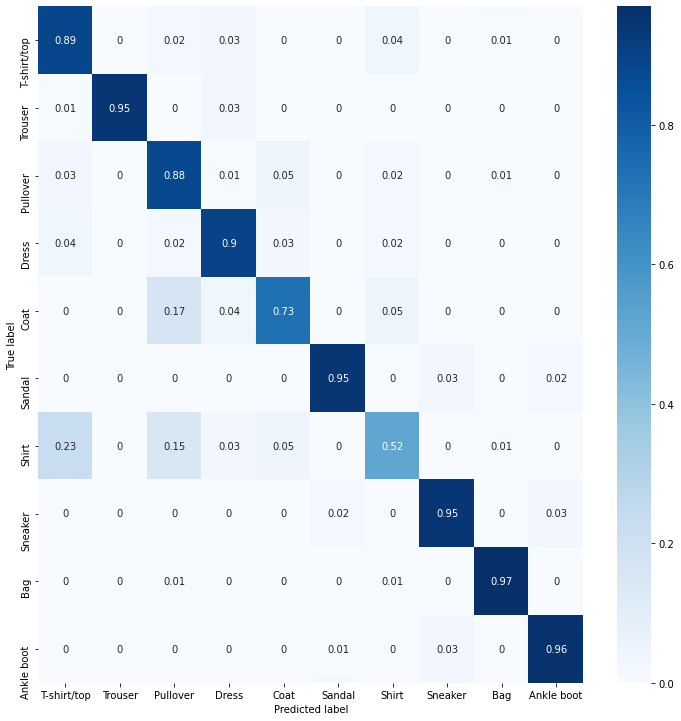

In [13]:
figure = plt.figure(figsize=(10, 10))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

##Predizioni

In [14]:
predictions = model_CNN_LSTM.predict(test_images)

print("Done")

Done


In [0]:
train_images = train_images.reshape(60000, rows, cols)

test_images = test_images.reshape(10000, rows, cols)

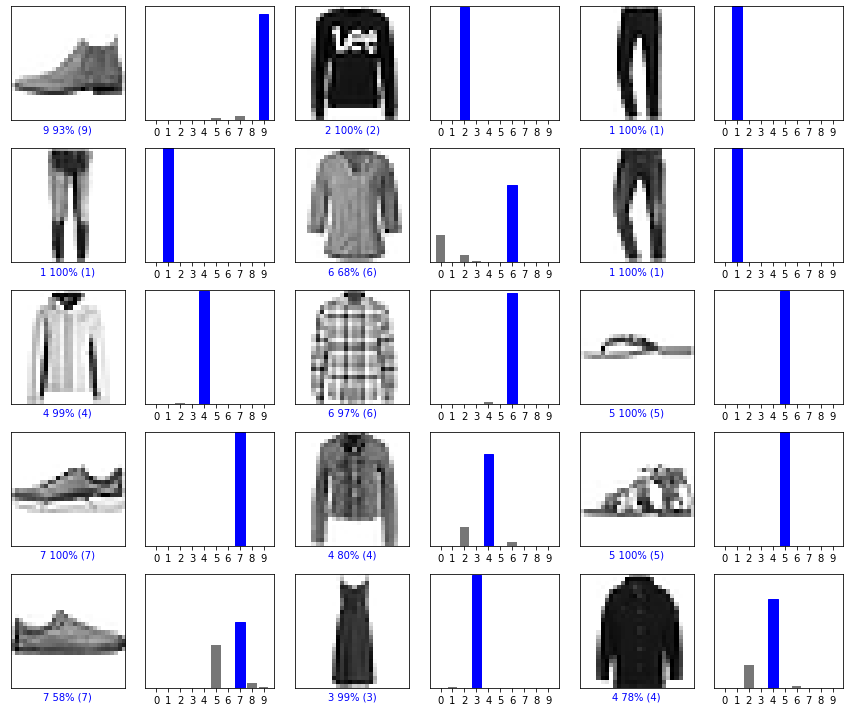

In [16]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], test_labels)
plt.tight_layout()
plt.show()